<h1>Table des matières<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Bibliothèque" data-toc-modified-id="Bibliothèque-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Bibliothèque</a></span></li><li><span><a href="#API-:-Récolte-des-données-sur-Yelp" data-toc-modified-id="API-:-Récolte-des-données-sur-Yelp-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>API : Récolte des données sur Yelp</a></span><ul class="toc-item"><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Conclusion</a></span><ul class="toc-item"><li><span><a href="#Récapitulatif" data-toc-modified-id="Récapitulatif-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Récapitulatif</a></span></li></ul></li></ul></li><li><span><a href="#NLP-:-Analyse-textuelle" data-toc-modified-id="NLP-:-Analyse-textuelle-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>NLP : Analyse textuelle</a></span><ul class="toc-item"><li><span><a href="#Chargement-du-jeu-de-données" data-toc-modified-id="Chargement-du-jeu-de-données-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Chargement du jeu de données</a></span></li><li><span><a href="#Nettoyage-des-données" data-toc-modified-id="Nettoyage-des-données-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Nettoyage des données</a></span><ul class="toc-item"><li><span><a href="#Filtrer-les-commentaires" data-toc-modified-id="Filtrer-les-commentaires-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Filtrer les commentaires</a></span></li><li><span><a href="#Récapitulatif" data-toc-modified-id="Récapitulatif-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>Récapitulatif</a></span></li></ul></li><li><span><a href="#Analyse-exploratoire" data-toc-modified-id="Analyse-exploratoire-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Analyse exploratoire</a></span></li><li><span><a href="#Bag-of-words" data-toc-modified-id="Bag-of-words-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Bag of words</a></span><ul class="toc-item"><li><span><a href="#Récapitulatif" data-toc-modified-id="Récapitulatif-3.4.1"><span class="toc-item-num">3.4.1&nbsp;&nbsp;</span>Récapitulatif</a></span></li></ul></li><li><span><a href="#TF-IDF" data-toc-modified-id="TF-IDF-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>TF-IDF</a></span></li></ul></li></ul></div>

# Améliorez le produit IA de votre start-up

![Logo Avis Restau](data/images/logo.png)

Avis Restau souhaite améliorer sa plateforme avec une **nouvelle fonctionnalité de collaboration** pour ses utilisateurs où ils pourront par exemple poster des avis et des photos sur leur restaurant préféré.

C’est aussi un moyen de mieux comprendre les avis postés par les utilisateurs.

Ider, le CTO de l’entreprise, à des souhaits que nous pouvons diviser en deux parties, textuel et visuel :
- Ses besoins textuels sont la détection des sujets d’insatisfaction présents dans les commentaires postés sur la plateforme.
- Ses besoins visuels sont la labellisation automatique des photos postées sur la plateforme. Par exemple, identifier les photos relatives à la nourriture, au décor dans le restaurant ou à l’extérieur du restaurant.

Cependant, Avis Restau manque de données. Nous allons donc utiliser la base de données de Yelp pour réaliser une preuve de concept.

Donc pour répondre à sa demande le projet sera divisé ainsi :
1. Récolte des données sur Yelp
2. Analyse textuelle
3. Analyse visuelle

## Bibliothèque

In [18]:
import os
import json
import matplotlib.pyplot as plt
import numpy as np
import requests
import pandas as pd
import seaborn as sns
import spacy

from dotenv import load_dotenv
from functions import *
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

nlp = spacy.load("fr_core_news_lg")
nlp.add_pipe('sentencizer')

load_dotenv()

True

## API : Récolte des données sur Yelp

<img src="data/images/api.png" width="150">

Yelp fournit un jeu de données textuel conséquent à cette adresse : https://www.yelp.com/dataset

Nous aurions pu jouer avec, à l’aide de Dask et Pandas (https://dask.org/) ou même encore avec PySpark. Néanmoins, au vu de la demande d’Ider, ce ne serait pas cohérent, car ce sont majoritairement des données provenant des États-Unis, il existe une différence dans le traitement du langage. De même, la différence géographique fait que les décorations et l’architecture changent d’un pays à un autre.

Nous allons donc utiliser l’API de Yelp pour collecter des données françaises et rester cohérents avec les objectifs. C’est aussi une sécurité qui permet d’assurer un fonctionnement optimal chez Avis Restau.

La documentation de l’API de Yelp (https://www.yelp.com/developers/documentation/v3/get_started) nous indique quelques limitations contraignantes pour la collecte des commentaires :

<img src="data/images/api_reviews.png" width="500">

Nous devons appeler l’api avec l’ID du restaurant et nous ne pouvons récupérer que 3 commentaires par ID.

Donc nous procéderons en 2 étapes :
1. Nous récupérons des ID de restaurants
2. Nous récupérerons des reviews pour chaque ID collecté

Il faudra être vigilant, car le nombre d’appels est aussi limité.

<img src="data/images/api_limit.png" width="500">

Ajoutés à cela, nous ne pouvons récupérer que 50 réponses par requête, nous allons donc ajouter aussi une boucle sur les requêtes.

<img src="data/images/api_offset.png" width="500">

In [2]:
# # Définir le point de terminaison, la clé api et l'en-tête
# url = 'https://api.yelp.com/v3/businesses/search'
# yelp_api_key = os.getenv("api_key")
# headers = {'Authorization': 'bearer %s' % yelp_api_key}

# # ID des restaurants
# ids = []
# names = []
# photos = []

# for i in range(4):
#     # Définir les paramètres de recherche des restaurants
#     params = {
#         'term': 'restaurant',
#         'limit': 50,
#         'location': 'France',
#         'offset': i * 50
#     }

#     # Faire la requête
#     response = requests.request('GET', url=url, headers=headers, params=params)
#     # reponse_txt = response_b.text

#     # Enregistrement des IDs
#     ids += [business['id'] for business in response.json()['businesses']]

# # Point de terminaison des commentaires
# url_review = "https://api.yelp.com/v3/businesses/"

# # Enregistrement des données dans une dataframe
# reviews = pd.DataFrame(columns=['review_id', 'business_id', 'rating', 'text'])
# pics = pd.DataFrame(columns=['business_id', 'name', 'photos'])

# # Récupération des commentaires
# review_count = 0
# for id in ids:
#     url = url_review + str(id) + "/reviews"
#     response = requests.request('GET',
#                                 url=url,
#                                 headers=headers,
#                                 params={'locale': 'fr_FR'})
#     for review in response.json()['reviews']:
#         reviews.loc[review_count] = [
#             review['id'], id, review['rating'], review['text']
#         ]
#         review_count += 1

# # Récupération des photos
# pic_count = 0
# for id in ids:
#     url = url_review + str(id)
#     response = requests.request('GET', url=url, headers=headers)
#     for pic in response.json():
#         pics.loc[pic_count] = [
#             id, response.json()['name'],
#             response.json()['photos']
#         ]
#         pic_count += 1

# # Enregistrement dans un fichier CSV
# appendDFToCSV_void(reviews, 'data/raw/yelp_reviews.csv')
# appendDFToCSV_void(pics, "data/raw/yelp_photos.csv")

### Conclusion

À l’aide de l’API de Yelp, nous avons récupéré des commentaires de restaurants français et des photos du lieu. Nous pouvons passer à la suite.

#### Récapitulatif

Nous avons collecté des données venant d’une API qui correspondent à un besoin défini :
- ✔️ une requête pour obtenir les données via l’API a été écrite, testée et renvoie bien des données en retour
- ✔️ seuls les champs nécessaires ont été récupérés 
- ✔️ au moins un filtre a été appliqué sur un des champs nécessaires pour ne collecter que les avis ayant les valeurs correspondantes sur ces champs 
- ✔️ les données collectées via l’API sont stockées dans un fichier utilisable (ex : fichier csv avec en colonne les différentes informations correspondant aux avis)

## NLP : Analyse textuelle

<img src="data/images/nlp.png" width="150">

A partir des données collecté, nous allons maintenant analyser les sujets d'insatisfactions.

Nous commencerons par charger le jeu de données, l'inspecter puis appliquer des filtres afin de ne garder que les commentaires négatifs.

### Chargement du jeu de données

In [3]:
# .set_index('review_id')
df_reviews = pd.read_csv('data/raw/yelp_reviews.csv')
df_reviews.shape

(576, 4)

### Nettoyage des données

#### Filtrer les commentaires

Pour répondre à la demande d'Ider sur les sujets d'insatisfaction, nous ne garderons que les commentaires avec un vote égale ou inférieur à 3.

In [4]:
df_bad_reviews = df_reviews.loc[df_reviews['rating'] <= 3]
df_bad_reviews = df_bad_reviews.reset_index()

In [5]:
df_bad_reviews

,index,review_id,business_id,rating,text
0,4,Z410PyFQsKjJ1ETb64N0ng,3J-vi78uhe3fZEOJDVBXqg,2,Au milieu d'une belle place située au coeur de...
1,12,yk6YpSutT9Y2CsotMpq6Og,zhHxYO0gH9Gh53D_J8XeOQ,3,"Sans plus....\r\nCadre agréable, cuisine très ..."
2,22,c1Lxnuq2Pee6UJLe9AaSMw,lBueZXrEbdSdvujDlQUB-w,3,"J'en attendais beaucoup du Louchébem, me voilà..."
3,25,XMsQ_LsJHRdn83RhUCQT6Q,JYJ0y_1we1IzMZ-UPVCQEg,1,Que fait Michel Del Burgo dans cette galère ? ...
4,30,v5K0mSDYbZZie80KIXE6cA,went0VaMbQc6XSOi_OJteg,3,"Pourquoi pas, si vous êtes dans le quartier. L..."
...,...,...,...,...,...
131,562,kzAh-86tsdKyd2Uvfv1law,eV3XeyDMWwT0E8o8nYodRQ,2,Bof.....\r\nA part la deco historiques et les ...
132,568,k3NTOfiDXpC-AqQ6p1ZPBA,7mqPWOaEnGOvgZl_eNQOww,3,"Un bistro sympa dans le centre de Paris, un bé..."
133,570,ueLFvzD8huByIn-hf1B2uA,bG6jhxY2YhHxD4P63kHD1A,1,Changement de propriétaire et du nom du restau...
134,572,IKIUe8748e3IR34A1WDkuQ,bG6jhxY2YhHxD4P63kHD1A,3,ACCUEIL & AMBIANCE\r\n\r\nLes serveurs sont ac...


In [6]:
# Lire le premier avis

print('Le premier commentaire est:\n\n', df_bad_reviews["text"][0])

Le premier commentaire est:

 Au milieu d'une belle place située au coeur de Paris, un restaurant medium en tout...
Le cadre est sublime, agréable et paisible en toute saison. C'est une...


Nous allons développer la fonction cleanData. Cette fonction va supprimer les stopwords, les ponctuations, convertir le texte en minuscules et préformer la lemmatisation.

**Les stopwords** : Les stopwords sont des mots qui sont particulièrement communs dans un corpus de texte et donc considérés comme peu informatifs.

**Lemmatisation** : La lemmatisation se réfère à la suppression des terminaisons flexionnelles et à la restitution de la forme de base ou de dictionnaire d'un mot, connue sous le nom de lemme.

In [7]:
# fonction de nettoyage des données


def cleanData(doc, stemming=False):
    doc = doc.lower()
    doc = nlp(doc)
    tokens = [tokens.lower_ for tokens in doc]
    tokens = [tokens for tokens in doc if (tokens.is_stop == False)]
    tokens = [tokens for tokens in tokens if (tokens.is_punct == False)]
    final_token = [token.lemma_ for token in tokens]

    return " ".join(final_token)

In [8]:
first_bad_review_cleaned = cleanData(df_bad_reviews["text"][0])
first_bad_review_cleaned

'milieu bel place situer coeur pari restaurant medium \r\n cadre sublime agréable paisible saison'

In [9]:
df_bad_reviews["cleaned"] = df_bad_reviews["text"].map(lambda x: cleanData(x))

In [10]:
df_bad_reviews["cleaned"] = df_bad_reviews["cleaned"].str.replace(
    r'\r+|\n+|\t+|\d+', '', regex=True)

In [11]:
df_bad_reviews["cleaned"]

0      milieu bel place situer coeur pari restaurant ...
1       cadre agréable cuisine simple patronne souria...
2      attendre beaucoup louchébem décevoir prendre p...
3      michel del burgo galère cuisine bon casserole ...
4      être quartier sélection vin verre correct from...
                             ...                        
131    bof  part deco historique coquillage loin haut...
132    bistro sympa centre pari bémol blanquette veau...
133    changement propriétaire nom restaurant catastr...
134    accueil ambiance  serveur accueillant sympathi...
135    restaurant cacher coeur charmant galerie véro ...
Name: cleaned, Length: 136, dtype: object

In [12]:
spacy.displacy.render(nlp(df_bad_reviews["cleaned"][91]),
                      jupyter=True,
                      style='ent')
spacy.displacy.render(nlp(df_bad_reviews["cleaned"][91]),
                      style='dep',
                      jupyter=True,
                      options={'distance': 120})

#### Récapitulatif

Effectuer un pré-traitement de données non structurées pour obtenir un jeu de données utilisable :
- ✔️ les champs de texte sont nettoyés : la ponctuation et les mots de liaison ont été retirés, les chaînes de caractères ont été mises en minuscule
- ✔️ au moins une parmi les trois transformations “stemming”, “tokenization”, “lemmatization” a été appliquée
- ✔️ l’enchaînement des étapes de nettoyage et de création de variables pour le texte a été automatisé et a été testé sur un exemple

### Analyse exploratoire

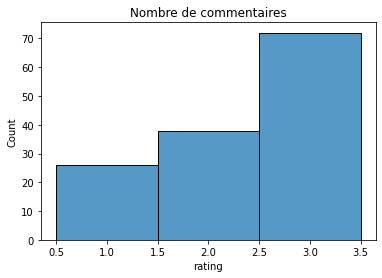

In [13]:
sns.histplot(df_bad_reviews['rating'], discrete=True)
plt.title('Nombre de commentaires')
plt.show()

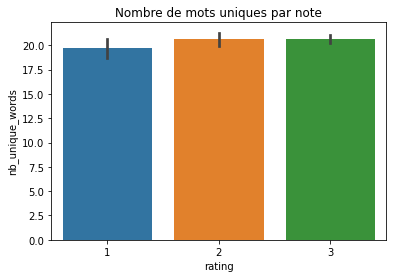

In [14]:
df_bad_reviews['nb_unique_words'] = df_bad_reviews.apply(
    lambda row: len(set(row['cleaned'])), axis=1)
sns.barplot(x=df_bad_reviews['rating'], y=df_bad_reviews['nb_unique_words'])
plt.title('Nombre de mots uniques par note')
plt.show()

### Bag of words

In [15]:
bow_vectorizer = CountVectorizer(min_df=2, ngram_range=(2, 2))
X_bow = bow_vectorizer.fit_transform(df_bad_reviews["cleaned"])
df_bow_bad_reviews = pd.DataFrame(X.toarray(),
                                  columns=bow_vectorizer.get_feature_names_out())
df_bow_bad_reviews

,accueil service,art déco,attendre beaucoup,bien manger,bien noter,boire verre,bon adresse,bon restaurant,bon restaurer,bon service,...,qualité prix,rapport qualité,restaurant situer,service impeccable,service rapide,service sympathique,tour eiffel,trop cher,trop élevé,être aller
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
132,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
133,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
134,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [16]:
bow_word_counts = np.array(np.sum(X, axis=0)).reshape((-1, ))
bow_top_words = np.array(bow_vectorizer.get_feature_names_out())

df_bow_top_words = pd.DataFrame({"mot": top_words, "nombre": word_counts})
df_bow_top_words.sort_values(by="nombre", ascending=False).head(10)

,mot,nombre
5,boire verre,4
23,prix élevé,4
33,être aller,3
25,rapport qualité,3
16,petit restaurant,3
12,café homme,3
24,qualité prix,3
21,prix bien,2
22,prix qualité,2
26,restaurant situer,2


#### Récapitulatif

Effectuer un pré-traitement de données non structurées pour obtenir un jeu de données utilisable :
- ✔️ au moins une variable bag-of-words a été créée incluant des étapes de nettoyage supplémentaires comme un seuil de fréquence et la normalisation des mots. 

### TF-IDF

In [25]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), 
                                binary=True)
X_tfidf = tfidf_vectorizer.fit_transform(df_bad_reviews["cleaned"])

df_tfidf_bad_reviews = pd.DataFrame(X_tfidf.toarray(),
                                  columns=tfidf_vectorizer.get_feature_names_out())
df_tfidf_bad_reviews

,abordable,absinthe,absinthe décider,ac,ac amie,acceptable,acceptable carte,accompagnement,accompagnement augmente,accompagner,...,être décevoir,être décider,être personne,être quartier,être tomber,œil,œil mettre,œuf,œuf mayonnaise,œuf techniquement
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.252893,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
132,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
133,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
134,0.234254,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
tfidf_word_counts = np.array(np.sum(X_tfidf, axis=0)).reshape((-1, ))
tfidf_top_words = np.array(tfidf_vectorizer.get_feature_names_out())

df_tfidf_top_words = pd.DataFrame({"mot": top_words, "nombre": word_counts})
df_tfidf_top_words.sort_values(by="nombre", ascending=False).head(10)

,mot,nombre
5,boire verre,4
23,prix élevé,4
33,être aller,3
25,rapport qualité,3
16,petit restaurant,3
12,café homme,3
24,qualité prix,3
21,prix bien,2
22,prix qualité,2
26,restaurant situer,2
